## Tidal stream generation in Agama

This tutorial illustrates several approaches for creating stellar streams from a tidally disrupting satellite:
- particle-spray method of Fardal+2015, as implemented in Gala;
- an approximate way of creating a warm stream by combining a cold stream (with no initial dispersion, essentially the streakline approach of Küpper+2012) with the linear perturbation theory;
- the restricted N-body simulation approach, which was used in the study of the Sagittarius stream (Vasiliev+2021).

Another stream generation method from the same family as particle spray and streakline is introduced in Chen+2024, with implementations for Agama, Gala and Galpy provided at https://github.com/ybillchen/particle_spray

In [1]:
import agama, numpy, matplotlib, matplotlib.pyplot as plt, time
%matplotlib inline
numpy.set_printoptions(precision=6, linewidth=999, suppress=True)
numpy.random.seed(111)
plt.rc('font', size=12)
plt.rc('figure', dpi=75)
plt.rc('mathtext', fontset='stix')
# all dimensional quantities are given in the units of 1 kpc, 1 km/s, 1 Msun;
agama.setUnits(length=1, velocity=1, mass=1)
timeUnitGyr = agama.getUnits()['time'] / 1e3  # time unit is 1 kpc / (1 km/s)
print('time unit: %.3f Gyr' % timeUnitGyr)

time unit: 0.978 Gyr


### Potentials and orbit integration
Check out `tutorial_potential.ipynb` for a detailed introduction to these topics.

This tutorial uses a static Milky Way potential, but one can generalize it to a time-dependent case (e.g, the Milky Way interaction with the LMC). See `example_lmc_mw_interaction.py` for an illustration of a simple "two-extended-bodies" approximation to the dynamics of this interaction (with frozen/non-deforming potentials of both galaxies). An alternative is to take an evolving and deforming potential extracted from a real N-body simulation, for instance, from the repository https://zenodo.org/records/7832267 accompanying the review paper "The effect of the LMC on the Milky Way system" ( http://adsabs.harvard.edu/abs/2023Galax..11...59V ).

### Model a stream using the particle spray method
The implementation below is adapted from Gala and consists of the following stages:
- take the present-day position and velocity of the stream progenitor ("satellite") and integrate its orbit in the potential of the "host" galaxy back in time for an interval `time_total`;
- for each point along the trajectory of the progenitor, create a pair of particles escaping through both Largange points with some spread in position and velocity;
- integrate the orbits of all particles forward in time from their respective "seeding times" up to present, producing the stream.

The routine `create_ic_particle_spray` implements the second stage, while the first and the third are implemented in `create_stream_particle_spray`; this roughly follows the split between "stream DF" and "stream generator" in Gala. The auxiliary routine `get_rj_vj_R` determines the Largange points along the progenitor orbit.

In [2]:
def get_rj_vj_R(pot_host, orbit_sat, mass_sat):
    """
    Compute the Jacobi radius, associated velocity, and rotation matrix
    for generating streams using particle-spray methods.
    Arguments:
        pot_host:  an instance of agama.Potential for the host galaxy.
        orbit_sat: the orbit of the satellite, an array of shape (N, 6).
        mass_sat:  the satellite mass (a single number or an array of length N).
    Return:
        rj:  Jacobi radius at each point on the orbit (length: N).
        vj:  velocity offset from the satellite at each point on the orbit (length: N).
        R:   rotation matrix converting from host to satellite at each point on the orbit (shape: N,3,3)
    """
    N = len(orbit_sat)
    x, y, z, vx, vy, vz = orbit_sat.T
    Lx = y * vz - z * vy
    Ly = z * vx - x * vz
    Lz = x * vy - y * vx
    r = (x*x + y*y + z*z)**0.5
    L = (Lx*Lx + Ly*Ly + Lz*Lz)**0.5
    # rotation matrices transforming from the host to the satellite frame for each point on the trajectory
    R = numpy.zeros((N, 3, 3))
    R[:,0,0] = x/r
    R[:,0,1] = y/r
    R[:,0,2] = z/r
    R[:,2,0] = Lx/L
    R[:,2,1] = Ly/L
    R[:,2,2] = Lz/L
    R[:,1,0] = R[:,0,2] * R[:,2,1] - R[:,0,1] * R[:,2,2]
    R[:,1,1] = R[:,0,0] * R[:,2,2] - R[:,0,2] * R[:,2,0]
    R[:,1,2] = R[:,0,1] * R[:,2,0] - R[:,0,0] * R[:,2,1]
    # compute  the second derivative of potential by spherical radius
    der = pot_host.eval(orbit_sat[:,0:3], der=True)
    d2Phi_dr2 = -(x**2  * der[:,0] + y**2  * der[:,1] + z**2  * der[:,2] +
                  2*x*y * der[:,3] + 2*y*z * der[:,4] + 2*z*x * der[:,5]) / r**2
    # compute the Jacobi radius and the relative velocity at this radius for each point on the trajectory
    Omega = L / r**2
    rj = (agama.G * mass_sat / (Omega**2 - d2Phi_dr2))**(1./3)
    vj = Omega * rj
    return rj, vj, R

In [3]:
def create_ic_particle_spray(orbit_sat, rj, vj, R, gala_modified=True):
    """
    Create initial conditions for particles escaping through Largange points,
    using the method of Fardal+2015
    Arguments:
        orbit_sat:  the orbit of the satellite, an array of shape (N, 6).
        rj:  Jacobi radius at each point on the orbit (length: N).
        vj:  velocity offset from the satellite at each point on the orbit (length: N).
        R:   rotation matrix converting from host to satellite at each point on the orbit (shape: N,3,3)
        gala_modified:  if True, use modified parameters as in Gala, otherwise the ones from the original paper.
    Return:
        initial conditions for stream particles, an array of shape (2*N, 6) - 
        two points for each point on the original satellite trajectory.
    """
    N = len(rj)
    # assign positions and velocities (in the satellite reference frame) of particles
    # leaving the satellite at both lagrange points (interleaving positive and negative offsets).
    rj = numpy.repeat(rj, 2) * numpy.tile([1, -1], N)
    vj = numpy.repeat(vj, 2) * numpy.tile([1, -1], N)
    R  = numpy.repeat(R, 2, axis=0)
    mean_x  = 2.0
    disp_x  = 0.5 if gala_modified else 0.4
    disp_z  = 0.5
    mean_vy = 0.3
    disp_vy = 0.5 if gala_modified else 0.4
    disp_vz = 0.5
    rx  = numpy.random.normal(size=2*N) * disp_x + mean_x
    rz  = numpy.random.normal(size=2*N) * disp_z * rj
    rvy =(numpy.random.normal(size=2*N) * disp_vy + mean_vy) * vj * (rx if gala_modified else 1)
    rvz = numpy.random.normal(size=2*N) * disp_vz * vj
    rx *= rj
    offset_pos = numpy.column_stack([rx,  rx*0, rz ])  # position and velocity of particles in the reference frame
    offset_vel = numpy.column_stack([rx*0, rvy, rvz])  # centered on the progenitor and aligned with its orbit
    ic_stream = numpy.tile(orbit_sat, 2).reshape(2*N, 6)   # same but in the host-centered frame
    ic_stream[:,0:3] += numpy.einsum('ni,nij->nj', offset_pos, R)
    ic_stream[:,3:6] += numpy.einsum('ni,nij->nj', offset_vel, R)
    return ic_stream

In [4]:
def create_stream_particle_spray(time_total, num_particles, pot_host, posvel_sat, mass_sat, gala_modified=True):
    """
    Construct a stream using the particle-spray method.
    Arguments:
        time_total:  duration of time for stream generation 
            (positive; orbit of the progenitor integrated from present day (t=0) back to time -time_total).
        num_particles:  number of points in the stream (even; divided equally between leading and trailing arms).
        pot_host:    an instance of agama.Potential for the host galaxy.
        posvel_sat:  present-day position and velocity of the satellite (array of length 6).
        mass_sat:    the satellite mass (a single number or an array of length num_particles//2).
        gala_modified:  if True, use modified parameters as in Gala, otherwise the ones from the original paper.
    Return:
        xv_stream: position and velocity of stream particles at present time (shape: num_particles, 6).
    """
    # number of points on the orbit: each point produces two stream particles (leading and trailing arms)
    N = num_particles//2

    # integrate the orbit of the progenitor from its present-day posvel (at time t=0)
    # back in time for an interval time_total, storing the trajectory at N points
    time_sat, orbit_sat = agama.orbit(
        potential=pot_host, ic=posvel_sat, time=-time_total, trajsize=N+1)
    # remove the 0th point (the present-day posvel) and reverse the arrays to make them increasing in time
    time_sat  = time_sat [1:][::-1]
    orbit_sat = orbit_sat[1:][::-1]

    # at each point on the trajectory, create a pair of seed initial conditions
    # for particles released at both Lagrange points
    rj, vj, R = get_rj_vj_R(pot_host, orbit_sat, mass_sat)
    ic_stream = create_ic_particle_spray(orbit_sat, rj, vj, R, gala_modified)
    time_seed = numpy.repeat(time_sat, 2)
    result = agama.orbit(
        potential=pot_host, ic=ic_stream,
        timestart=time_seed,  # starting time for each orbit (negative)
        time=-time_seed,      # integration time for each orbit: time_start + time = 0 (end time, i.e. now)
        trajsize=1)           # each orbit produces just one point (at the end of the integration)
    # 0th column is the array of times (here, just one element for each orbit, i.e. its end time),
    # 1st column is the trajectory (here, one end point per orbit)
    xv_stream = numpy.vstack(result[:,1])
    
    return xv_stream

### Illustrate the method on the Pal 5 stream (same example as in Gala tutorial).

10000 orbits complete (1.083e+04 orbits/s)


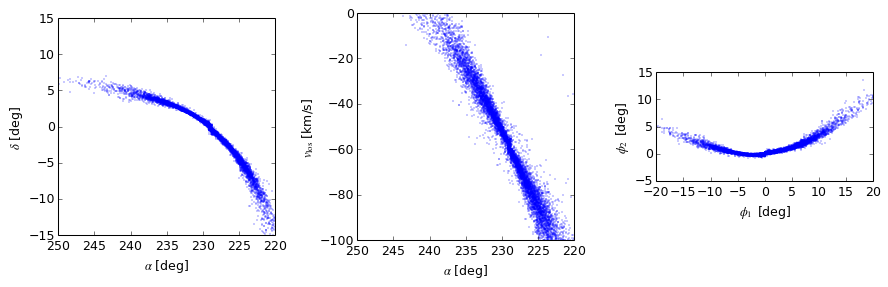

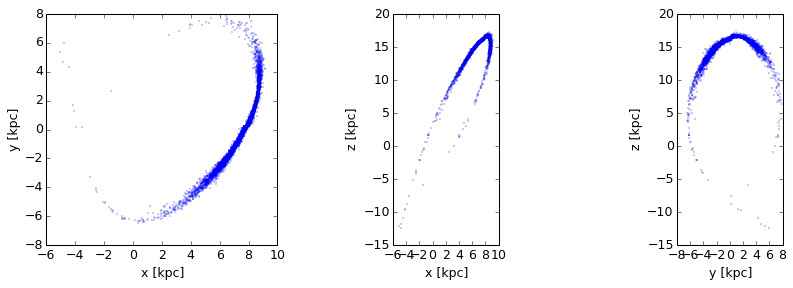

In [5]:
# sky coordinates in degrees, distance in kpc, proper motion in mas/yr, heliocentric line-of-sight velocity in km/s
ra0, dec0 = 229.0, -0.124
dist0 = 22.9
pmra0, pmdec0 = -2.296, -2.257
vlos0 = -58.7

# use built-in coordinate conversion routines from Agama instead of Astropy: faster, no external dependencies,
# but need to do some extra steps, e.g., convert from degrees to radians and
# from mas/yr to km/s/kpc, the base units used throughout this example (the factor 4.74 below)
l0, b0, pml0, pmb0 = agama.transformCelestialCoords(agama.fromICRStoGalactic,
    ra0*numpy.pi/180, dec0*numpy.pi/180, pmra0, pmdec0)
posvel_sat = agama.getGalactocentricFromGalactic(l0, b0, dist0, pml0*4.74, pmb0*4.74, vlos0)

# Rotation matrix for conversion from ICRS to the Pal5 stream coordinate system (taken from Gala)
fromICRStoPal5 = numpy.array([
    [-0.65582036, -0.75491389, -0.00216422],
    [-0.62865701,  0.54771927, -0.55208149],
    [ 0.41795937, -0.36070573, -0.83378735],
])

# fiducial potential of the Milky Way, consisting of a disk and a spherical halo
pot_host = agama.Potential(
    dict(type='MiyamotoNagai', mass=6e10, scaleRadius=3.5, scaleHeight=0.28),
    dict(type='NFW', mass=1e12, scaleRadius=20)
)

mass_sat   = 2.5e4  # in Msun
radius_sat = 0.004  # in kpc
time_total = 4.0    # in time units (0.978 Gyr)
num_particles = int(1e4)  # number of particles in the stream

xv_stream = create_stream_particle_spray(time_total, num_particles, pot_host, posvel_sat, mass_sat)

# same coordinate conversion steps in reverse; also convert to stream coordinates (phi1 along, phi2 across)
def get_observed_coords(xv):
    l, b, dist, pml, pmb, vlos = agama.getGalacticFromGalactocentric(*xv.T)
    ra, dec = agama.transformCelestialCoords(agama.fromGalactictoICRS, l, b)
    phi1, phi2 = agama.transformCelestialCoords(fromICRStoPal5, ra, dec)
    return ra * 180/numpy.pi + 360, dec * 180/numpy.pi, vlos, phi1 * 180/numpy.pi, phi2 * 180/numpy.pi

ra, dec, vlos, phi1, phi2 = get_observed_coords(xv_stream)
ax = plt.subplots(1, 3, figsize=(12,4))[1]
ax[0].plot(ra, dec, 'bo', ms=1, mew=0)
ax[0].set_xlim(250, 220)
ax[0].set_ylim(-15, 15)
ax[0].set_aspect('equal')
ax[0].set_xlabel(r'$\alpha$ [deg]')
ax[0].set_ylabel(r'$\delta$ [deg]')
ax[1].plot(ra, vlos, 'bo', ms=1, mew=0)
ax[1].set_xlim(250, 220)
ax[1].set_ylim(-100, 0)
ax[1].set_xlabel(r'$\alpha$ [deg]')
ax[1].set_ylabel(r'$v_{\rm los}$ [km/s]')
ax[2].plot(phi1, phi2, 'bo', ms=1, mew=0)
ax[2].set_xlim(-20, 20)
ax[2].set_ylim(-5, 15)
ax[2].set_aspect('equal')
ax[2].set_xlabel(r'$\phi_1$ [deg]')
ax[2].set_ylabel(r'$\phi_2$ [deg]')
plt.tight_layout()

ax = plt.subplots(1, 3, figsize=(12,4))[1]
ax[0].plot(xv_stream[:,0], xv_stream[:,1], 'bo', ms=1, mew=0)
ax[1].plot(xv_stream[:,0], xv_stream[:,2], 'bo', ms=1, mew=0)
ax[2].plot(xv_stream[:,1], xv_stream[:,2], 'bo', ms=1, mew=0)
ax[0].set_aspect('equal')
ax[0].set_xlabel('x [kpc]')
ax[0].set_ylabel('y [kpc]')
ax[1].set_aspect('equal')
ax[1].set_xlabel('x [kpc]')
ax[1].set_ylabel('z [kpc]')
ax[2].set_aspect('equal')
ax[2].set_xlabel('y [kpc]')
ax[2].set_ylabel('z [kpc]')
plt.tight_layout()
None

### Include additional potential components during stream generation
At the very least, one could include the potential of the progenitor moving on its orbit (here assumed to be constant, but it is straighforward to let it evolve with time, e.g. using the "scale" modifier to change its mass and scale radius).

A more complicated example is the perturbation resulting from a flyby of a dark subhalo, which produces a gap in the stream. In this tutorial, we illustrate both effects, but the subhalo part serves as a demonstration only, and should be adapted to more realistic scenarios.

10000 orbits complete (1.205e+04 orbits/s)
10000 orbits complete (3945 orbits/s)


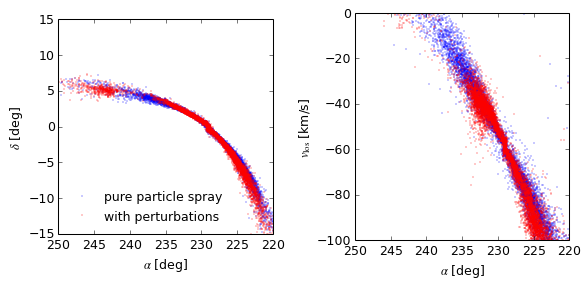

In [6]:
def create_stream_particle_spray_with_progenitor_and_perturber(
    time_total, num_particles, pot_host, posvel_sat, mass_sat, radius_sat, gala_modified=True, add_perturber=True):
    """
    Construct a stream using the particle-spray method.
    Arguments:
        time_total:  duration of time for stream generation 
            (positive; orbit of the progenitor integrated from present day (t=0) back to time -time_total).
        num_particles:  number of points in the stream (even; divided equally between leading and trailing arms).
        pot_host:    an instance of agama.Potential for the host galaxy.
        posvel_sat:  present-day position and velocity of the satellite (array of length 6).
        mass_sat:    the satellite mass (a single number).
        radius_sat:  the scale radius of the satellite (assuming a Plummer profile).
        gala_modified:  if True, use modified parameters as in Gala, otherwise the ones from the original paper.
        add_perturber:  if True, add a perturbation from a fiducial flyby of a dark subhalo
        (no tunable parameters are available - this code should be adapted to specific scenarios).
    Return:
        xv_stream: position and velocity of stream particles at present time, evolved in the host potential only
        (shape: num_particles, 6),
        xv_perturbed: same but including the potential of the progenitor and the perturber.
    """
    # number of points on the orbit: each point produces two stream particles (leading and trailing arms)
    N = num_particles//2

    # integrate the orbit of the progenitor from its present-day posvel (at time t=0)
    # back in time for an interval time_total, storing the trajectory at N points
    time_init = -time_total
    time_sat, orbit_sat = agama.orbit(
        potential=pot_host, ic=posvel_sat, time=time_init, trajsize=N+1)
    # remove the 0th point (the present-day posvel) and reverse the arrays to make them increasing in time
    time_sat  = time_sat [1:][::-1]
    orbit_sat = orbit_sat[1:][::-1]

    # at each point on the trajectory, create a pair of seed initial conditions
    # for particles released at both Lagrange points
    rj, vj, R = get_rj_vj_R(pot_host, orbit_sat, mass_sat)
    ic_stream = create_ic_particle_spray(orbit_sat, rj, vj, R, gala_modified)
    time_seed = numpy.repeat(time_sat, 2)
    result = agama.orbit(
        potential=pot_host, ic=ic_stream,
        timestart=time_seed,  # starting time for each orbit (negative)
        time=-time_seed,      # integration time for each orbit: time_start + time = 0 (end time, i.e. now)
        trajsize=1)           # each orbit produces just one point (at the end of the integration)
    # 0th column is the array of times (here, just one element for each orbit, i.e. its end time),
    # 1st column is the trajectory (here, one end point per orbit)
    xv_stream = numpy.vstack(result[:,1])

    # the gravitational potential of the progenitor moving on its orbit
    pot_sat = agama.Potential(
        type='Plummer', mass=mass_sat, scaleRadius=radius_sat, center=numpy.column_stack([time_sat, orbit_sat]))

    # the perturber: a dark subhalo flying through the stream track at some point denoted as
    # "xv_perturber_flyby", which coincides with the point on the actual orbit of the progenitor,
    # but has a different velocity, and the flyby time is slightly later than the time at which
    # the progenitor passes through the same point.
    xv_perturber_flyby = orbit_sat[len(orbit_sat)//2]  # crossing point at the middle of the progenitor orbit
    xv_perturber_flyby[3:6] += numpy.random.normal(size=3) * 50.0  # modify the velocity of the perturber
    time_flyby = -time_total * 0.4   # set the flyby at a different time than the progenitor

    # We could have approximated the perturber's motion as a straight line, but to make it more realistic,
    # we put it onto an actual orbit in the same Galactic potential.
    # The way to construct such an orbit is slightly convolved:
    # First, we integrate the orbit from the flyby time and corresponding point back in time
    # to the initial time of the stream simulation.
    # The returned value is a tuple (timestamps, trajectory), of which we need only the trajectory,
    # and select the last (and only) point, i.e. the position/velocity of the perturber at time_init
    xv_perturber_init = agama.orbit(
        potential=pot_host, ic=xv_perturber_flyby, time=time_init-time_flyby, timestart=time_flyby, trajsize=1
    )[1][0]
    # Then we integrate the perturber's orbit forward in time from this initial point up to present,
    # storing the output at every internal timestep of the integrator (requested by trajsize=0)
    traj_perturber = numpy.column_stack(agama.orbit(
        potential=pot_host, ic=xv_perturber_init, time=time_total, timestart=time_init, trajsize=0))
    # and finally, create the NFW potential of the perturber moving on its orbit
    pot_perturber = agama.Potential(type='nfw', mass=2e7, scaleRadius=0.05, center=traj_perturber)

    # The total potential is now composed of three parts: the host galaxy, the progenitor, and the perturber
    if add_perturber:
        pot_total = agama.Potential(pot_host, pot_sat, pot_perturber)
    else:
        pot_total = agama.Potential(pot_host, pot_sat)  # less dramatic

    # create a version of the stream in the new potential
    xv_stream_perturbed = numpy.vstack(agama.orbit(
        potential=pot_total, ic=ic_stream, timestart=time_seed, time=-time_seed, trajsize=1)[:,1])

    return xv_stream, xv_stream_perturbed

xv_stream, xv_stream_perturbed = create_stream_particle_spray_with_progenitor_and_perturber(
    time_total, num_particles, pot_host, posvel_sat, mass_sat, radius_sat)

ra, dec, vlos, phi1, phi2 = get_observed_coords(xv_stream)
p_ra, p_dec, p_vlos, p_phi1, p_phi2 = get_observed_coords(xv_stream_perturbed)
ax = plt.subplots(1, 2, figsize=(8,4))[1]
ax[0].plot(ra, dec, 'bo', ms=1, mew=0, label='pure particle spray')
ax[1].plot(ra, vlos, 'bo', ms=1, mew=0)
ax[0].plot(p_ra, p_dec, 'ro', ms=1, mew=0, label='with perturbations')
ax[1].plot(p_ra, p_vlos, 'ro', ms=1, mew=0)
ax[0].set_xlim(250, 220)
ax[0].set_ylim(-15, 15)
ax[0].set_aspect('equal')
ax[0].set_xlabel(r'$\alpha$ [deg]')
ax[0].set_ylabel(r'$\delta$ [deg]')
ax[1].set_xlim(250, 220)
ax[1].set_ylim(-100, 0)
ax[1].set_xlabel(r'$\alpha$ [deg]')
ax[1].set_ylabel(r'$v_{\rm los}$ [km/s]')
ax[0].legend(loc='lower left', frameon=False, fontsize=12, numpoints=1)
plt.tight_layout()

### Using perturbation theory to upsample the stream
This idea is taken from Galax (a rewrite of Gala in Jax).

Instead of creating "warm" initial conditions for particles at Largange points (with some initial spread), one can place them exactly at Largange points, and compute their orbits together with derivatives (i.e. the Jacobian $J\equiv d w_f / d w_i$ of final phase-space coordinates $w_f$ w.r.t. initial conditions $w_i$). Then one may use the first-order (linear) perturbation theory reconstruct the present-day position and velocity of stream particles that would be seeded in the vicinity of Lagrange points with some spread. 

The elegance of this approach is that for each "cold" particle whose orbit was actually integrated, one can place many "warm" particles at present day at essentially no extra cost, although in the example below we use just one.

Unfortunately, this linearized prediction eventually deviates from the true trajectories of "warm" particles. The plot demonstrates the difference between the actual "warm" stream and the "cold" one with or without first-order corrections. The cold stream is considerably shorter than the warm one, and therefore covers a smaller fraction of the curved progenitor orbit. The first-order correction reduces the difference between the warm and cold stream by approximately an order of magnitude, but the linear extrapolation of deviation vectors means that the curved curved shape of the most distant parts of the stream is not recovered well. The difference is even more dramatic when using `gala_modified` parameters, which produce a warmer stream.

1000 orbits complete (5495 orbits/s)
10000 orbits complete (1.205e+04 orbits/s)


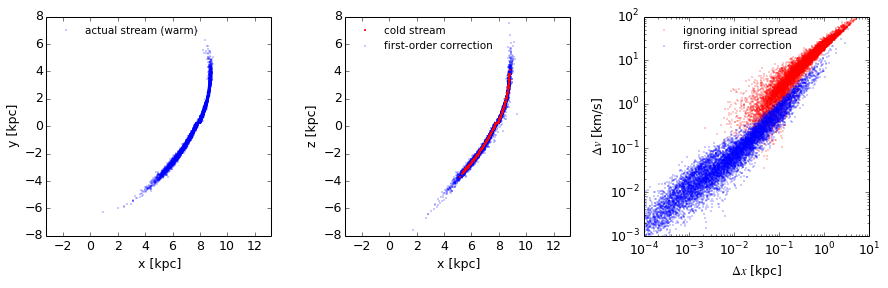

In [7]:
def create_stream_particle_spray_linearized(
    time_total, num_particles, pot_host, posvel_sat, mass_sat, gala_modified=True, upsample_factor=10):
    """
    Illustrate the method for creating warm streams by linearized corrections of cold streams.
    Arguments are the same as above, with upsample_factor controlling the number of "warm" particles
    produced for each "cold" seed particle.
    This method is not very useful in practice, so the routine just shows plots and returns nothing.
    """

    num_seeds = num_particles//upsample_factor  # number of seed points for cold initial conditions
    N = num_seeds//2                            # number of steps in the progenitor orbit 
    time_sat, orbit_sat = agama.orbit(
        potential=pot_host, ic=posvel_sat, time=-time_total, trajsize=N+1)
    time_sat  = time_sat [1:][::-1]
    orbit_sat = orbit_sat[1:][::-1]

    # at each point on the trajectory, create a pair of seed initial conditions
    # for particles released at both Lagrange points ("cold", i.e. no spread)
    rj, vj, R = get_rj_vj_R(pot_host, orbit_sat, mass_sat)
    rj = numpy.repeat(rj, 2) * numpy.tile([1, -1], N)
    vj = numpy.repeat(vj, 2) * numpy.tile([1, -1], N)
    R  = numpy.repeat(R, 2, axis=0)
    mean_x  = 2.0
    mean_vy = 0.3
    offset_pos = numpy.column_stack([rj*mean_x,  rj*0, rj*0])
    offset_vel = numpy.column_stack([vj*0, vj*mean_vy, vj*0])
    ic_cold = numpy.tile(orbit_sat, 2).reshape(num_seeds, 6)
    ic_cold[:,0:3] += numpy.einsum('ni,nij->nj', offset_pos, R)
    ic_cold[:,3:6] += numpy.einsum('ni,nij->nj', offset_vel, R)

    time_seed = numpy.repeat(time_sat, 2)
    result_cold, jacobian = agama.orbit(
        potential=pot_host, ic=ic_cold,
        timestart=time_seed,  # starting time for each orbit (negative)
        time=-time_seed,      # integration time for each orbit: time_start + time = 0 (end time, i.e. now)
        trajsize=1,           # each orbit produces just one point (at the end of the integration)
        der=True)             # compute the derivatives of final phase-space coords w.r.t. initial ones
    xv_cold = numpy.vstack(result_cold[:,1])

    # for each trajectory of a "cold" stream particle with index n, jacobian[n,i,j] = d w_{final,i} / d w_{init,j}
    jacobian = numpy.vstack(jacobian.reshape(-1)).reshape(num_seeds, 6, 6)
    
    # for each "cold" seed point, create "upsample_factor" warm initial conditions
    rj = numpy.repeat(rj, upsample_factor)
    vj = numpy.repeat(vj, upsample_factor)
    R  = numpy.repeat(R,  upsample_factor, axis=0)
    disp_x  = 0.5 if gala_modified else 0.4
    disp_z  = 0.5
    disp_vy = 0.5 if gala_modified else 0.4
    disp_vz = 0.5
    numpy.random.seed(1)
    rx  = numpy.random.normal(size=len(rj)) * disp_x + mean_x
    rz  = numpy.random.normal(size=len(rj)) * disp_z * rj
    rvy =(numpy.random.normal(size=len(rj)) * disp_vy + mean_vy) * vj * (rx if gala_modified else 1)
    rvz = numpy.random.normal(size=len(rj)) * disp_vz * vj
    rx *= rj
    # difference between the "warm" initial conditions and the corresponding "cold" ones,
    # in the reference frame centered on the progenitor and aligned with its orbit
    delta_pos = numpy.column_stack([rx,  rx*0, rz ]) - numpy.repeat(offset_pos, upsample_factor, axis=0)
    delta_vel = numpy.column_stack([rx*0, rvy, rvz]) - numpy.repeat(offset_vel, upsample_factor, axis=0)
    # same but in the host reference frame
    delta_ic  = numpy.column_stack([
        numpy.einsum('ni,nij->nj', delta_pos, R),
        numpy.einsum('ni,nij->nj', delta_vel, R) ])
    
    # linearized present-day phase-space coordinates of "warm" particles
    xv_linear = (numpy.repeat(xv_cold, upsample_factor, axis=0) +
                 numpy.einsum('nij,ni->nj', numpy.repeat(jacobian, upsample_factor, axis=0), delta_ic))
    
    # actual present-day phase-space coordinates of "warm" particles
    # (for comparison purposes only; if the method works well, these would not need to be computed!)
    ic_warm = numpy.repeat(ic_cold, upsample_factor, axis=0) + delta_ic
    time_warm = numpy.repeat(time_seed, upsample_factor)
    xv_actual = numpy.vstack(agama.orbit(
        potential=pot_host, ic=ic_warm, timestart=time_warm, time=-time_warm, trajsize=1)[:,1])

    # show the linear and the actual streams side-by-side
    plt.figure(figsize=(12,4))
    ax = [plt.subplot(1, 3, 1)]
    ax.append(plt.subplot(1, 3, 2, sharex=ax[0], sharey=ax[0]))
    ax.append(plt.subplot(1, 3, 3))
    ax[0].plot(xv_actual[:,0], xv_actual[:,1], 'bo', ms=1, mew=0, label='actual stream (warm)')
    ax[1].plot(xv_cold  [:,0], xv_cold  [:,1], 'ro', ms=2, mew=0, label='cold stream', zorder=10)
    ax[1].plot(xv_linear[:,0], xv_linear[:,1], 'bo', ms=1, mew=0, label='first-order correction')
    ax[2].plot(
        numpy.sum((numpy.repeat(xv_cold[:,0:3], upsample_factor, axis=0) - xv_actual[:,0:3])**2, axis=1)**0.5,
        numpy.sum((numpy.repeat(xv_cold[:,3:6], upsample_factor, axis=0) - xv_actual[:,3:6])**2, axis=1)**0.5,
        'ro', ms=1, mew=0, label='ignoring initial spread')
    ax[2].plot(
        numpy.sum((xv_linear[:,0:3] - xv_actual[:,0:3])**2, axis=1)**0.5,
        numpy.sum((xv_linear[:,3:6] - xv_actual[:,3:6])**2, axis=1)**0.5,
        'bo', ms=1, mew=0, label='first-order correction')
    ax[0].set_aspect('equal')
    ax[0].set_xlabel('x [kpc]')
    ax[0].set_ylabel('y [kpc]')
    ax[1].set_aspect('equal')
    ax[1].set_xlabel('x [kpc]')
    ax[1].set_ylabel('z [kpc]')
    ax[2].set_xlabel(r'$\Delta x$ [kpc]')
    ax[2].set_ylabel(r'$\Delta v$ [km/s]')
    ax[2].set_xscale('log')
    ax[2].set_yscale('log')
    ax[2].set_xlim(1e-4, 1e1)
    ax[2].set_ylim(1e-3, 1e2)
    ax[0].legend(loc='upper left', frameon=False, numpoints=1, fontsize=10)
    ax[1].legend(loc='upper left', frameon=False, numpoints=1, fontsize=10)
    ax[2].legend(loc='upper left', frameon=False, numpoints=1, fontsize=10)
    plt.tight_layout()
    
create_stream_particle_spray_linearized(
    time_total, num_particles, pot_host, posvel_sat, mass_sat, gala_modified=False)

### Model a stream using the restricted N-body method
*this part is adapted from `example_tidal_stream.py`*

The satellite galaxy moves in the host galaxy as a single massive body (i.e., it creates its own gravitational potential). To produce the tidal stream and to determine the mass evolution of the satellite, it is also represented by test particles, which do not interact between themselves, but move in the time-dependent potential created by the host and the moving satellite.

The potential and mass of the satellite are then recomputed every so often from these particles, closing the loop. The update interval is much longer than the timestep of the full N-body simulation, because the orbits of particles are evolved with high precision using an adaptive-timestep integrator, and the frequency of updates should be sufficient to resolve the mass and structural evolution of the satellite rather than particle trajectories themselves.

In [8]:
def create_stream_restricted_nbody(
    time_total, num_particles, pot_host, posvel_sat, mass_sat, radius_sat):
    """
    Create a stream using the "restricted N-body method", which follow the orbits of particles 
    both inside the progenitor and after they become stripped, and updates the potential of the progenitor
    self-consistently (approximating it as spherical).
    Arguments:
        time_total:  duration of time for stream generation 
            (positive; orbit of the progenitor integrated from present day (t=0) back to time -time_total).
        num_particles:  number of particles in the simulation.
        pot_host:    an instance of agama.Potential for the host galaxy.
        posvel_sat:  present-day position and velocity of the satellite (array of length 6).
        mass_sat:    initial satellite mass.
        radius_sat:  initial scale radius of the Plummer profile of the satellite.
    Return:
        xv_stream: position and velocity of stream particles at present time (shape: num_particles, 6).

    """
    
    # integrate the orbit of the progenitor from its present-day posvel (at time t=0) back in time
    # for an interval time_total, storing the trajectory at every timestep of the ODE integrator
    # (as specified by trajsize=0) to ensure an accurate interpolation
    time_sat, orbit_sat = agama.orbit(potential=pot_host, ic=posvel_sat, time=-time_total, trajsize=0)

    # reverse the arrays to make them increasing in time
    time_sat  = time_sat [::-1]
    orbit_sat = orbit_sat[::-1]
    # create the spline interpolators for each coordinate of the progenitor trajectory
    traj_x = agama.Spline(time_sat, orbit_sat[:,0], der=orbit_sat[:,3])
    traj_y = agama.Spline(time_sat, orbit_sat[:,1], der=orbit_sat[:,4])
    traj_z = agama.Spline(time_sat, orbit_sat[:,2], der=orbit_sat[:,5])

    # initial potential of the satellite (a Plummer profile)
    pot_sat  = agama.Potential(type='Plummer', mass=mass_sat, scaleRadius=radius_sat)

    # create a spherical isotropic DF for the satellite and sample it with particles
    # (note: the sampling will be different each time you run this cell, it does not use numpy random seed)
    df_sat = agama.DistributionFunction(type='QuasiSpherical', potential=pot_sat)
    xv, mass = agama.GalaxyModel(pot_sat, df_sat).sample(num_particles)
    print('velocity dispersion in the progenitor: %g km/s' % numpy.mean(xv[:,3:6]**2 / 3)**0.5)

    # shift the particles to the initial position/velocity of the satellite
    xv += orbit_sat[0]

    time_begin = -time_total  # start of the simulation
    time_end   = 0.0
    time_index = 0
    wallclock_begin = time.time()
    while time_begin < time_end:
        # update interval is set to 10 timesteps of the original orbit integrator,
        # this choice makes it possible to resolve the rapid evolution around pericentre passages
        # in sufficient detail (though we still approximate the satellite potential as spherical)
        time_index = min(time_index+10, len(time_sat)-1)

        # initialize the time-dependent total potential (host + moving sat) on this time interval
        pot_sat_moving = agama.Potential(potential=pot_sat, center=numpy.column_stack([time_sat, orbit_sat]))
        pot_total = agama.Potential(pot_host, pot_sat_moving)

        # compute the trajectories of all particles moving in the combined potential of
        # the host galaxy and the moving satellite.
        # to speed up computations, we use a less stringent accuracy parameter than the default value of 1e-8;
        # however, if one further loosens it to 1e-4, the satellite gets artificially disrupted too quickly!
        xv = numpy.vstack(agama.orbit(ic=xv, potential=pot_total, trajsize=1,
            time=time_sat[time_index]-time_begin, timestart=time_begin, verbose=False, accuracy=1e-6)[:,1])

        # update the potential of the satellite (using a spherical monopole approximation),
        # subtracting the position of the satellite centre at the current time from particle coords
        time_begin = time_sat[time_index]
        xv_rel = xv - orbit_sat[time_index]
        pot_sat = agama.Potential(type='multipole', particles=(xv_rel[:,0:3], mass), symmetry='s')
        bound = pot_sat.potential(xv_rel[:,0:3]) + 0.5 * numpy.sum(xv_rel[:,3:6]**2, axis=1) < 0
        print('t=%6.3f, Phi(0)=%6.2f, bound mass=%5.0f' %
            (time_begin, pot_sat.potential(0,0,0), numpy.sum(mass[bound])))
    
    print('wallclock time: %.1f s' % (time.time() - wallclock_begin))
    return xv

velocity dispersion in the progenitor: 0.765722 km/s
t=-3.906, Phi(0)=-17.96, bound mass=24752
t=-3.814, Phi(0)=-17.66, bound mass=24595
t=-3.758, Phi(0)=-17.45, bound mass=24338
t=-3.714, Phi(0)=-17.40, bound mass=24258
t=-3.546, Phi(0)=-17.33, bound mass=24051
t=-3.533, Phi(0)=-17.31, bound mass=23993
t=-3.375, Phi(0)=-16.69, bound mass=23826
t=-3.319, Phi(0)=-17.01, bound mass=23748
t=-3.256, Phi(0)=-16.52, bound mass=23561
t=-3.179, Phi(0)=-16.34, bound mass=23474
t=-3.058, Phi(0)=-16.00, bound mass=23314
t=-3.027, Phi(0)=-15.94, bound mass=23239
t=-2.884, Phi(0)=-15.76, bound mass=23121
t=-2.811, Phi(0)=-15.61, bound mass=23012
t=-2.785, Phi(0)=-15.53, bound mass=22937
t=-2.601, Phi(0)=-15.18, bound mass=22802
t=-2.578, Phi(0)=-14.90, bound mass=22762
t=-2.474, Phi(0)=-14.87, bound mass=22587
t=-2.411, Phi(0)=-14.74, bound mass=22564
t=-2.311, Phi(0)=-14.45, bound mass=22430
t=-2.296, Phi(0)=-14.52, bound mass=22390
t=-2.116, Phi(0)=-14.26, bound mass=22295
t=-2.082, Phi(0)=-14.19

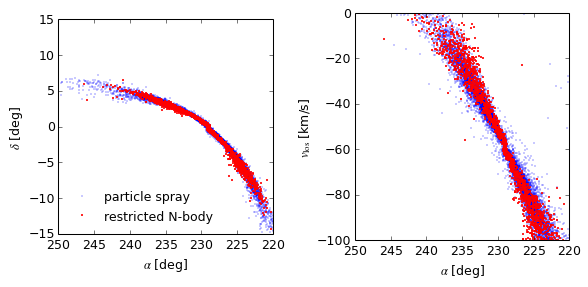

In [9]:
xv_nbody = create_stream_restricted_nbody(time_total, num_particles, pot_host, posvel_sat, mass_sat,
    1.5 * radius_sat)  # make the radius larger to facilitate the tidal disruption
n_ra, n_dec, n_vlos, n_phi1, n_phi2 = get_observed_coords(xv_nbody)
ax = plt.subplots(1, 2, figsize=(8,4))[1]
ax[0].plot(ra, dec, 'bo', ms=1, mew=0, label='particle spray')
ax[1].plot(ra, vlos, 'bo', ms=1, mew=0)
ax[0].plot(n_ra, n_dec, 'ro', ms=2, mew=0, label='restricted N-body')
ax[1].plot(n_ra, n_vlos, 'ro', ms=2, mew=0)
ax[0].set_xlim(250, 220)
ax[0].set_ylim(-15, 15)
ax[0].set_aspect('equal')
ax[0].set_xlabel(r'$\alpha$ [deg]')
ax[0].set_ylabel(r'$\delta$ [deg]')
ax[1].set_xlim(250, 220)
ax[1].set_ylim(-100, 0)
ax[1].set_xlabel(r'$\alpha$ [deg]')
ax[1].set_ylabel(r'$v_{\rm los}$ [km/s]')
ax[0].legend(loc='lower left', frameon=False, fontsize=12, numpoints=1)
plt.tight_layout()